In [19]:
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
df = pd.read_csv('../data/new/albums_final.csv')

In [3]:
img_dir = "../../album_images"
df['filepath'] = df['album_id'].apply(lambda x: os.path.join(img_dir, (x + '.jpg')))
df = df[df['filepath'].apply(os.path.exists)]  # Drop missing files

In [7]:
# Parameters
image_size = (64, 64)  # Match your CNN input shape
label_column = 'popularity'

X = []
y = []

for _, row in df.iterrows():
    try:
        img = Image.open(row['filepath']).resize(image_size).convert('RGB')  # force RGB
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading image {row['filepath']}: {e}")

X = np.array(X)
y = np.array(y).astype(np.float32)  # Regression → float labels


In [11]:
# Wrap in tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Split into train/val
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Setup performance pipeline
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

In [15]:
model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 3
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Output layer (regression)
model.add(layers.Dense(1))

# Early stopping
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

# Fit the model
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])

/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,169 (2.47 MB)

 Trainable params: 646,721 (2.47 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 3459.0222 - mean_absolute_error: 56.4980 - val_loss: 1378.7444 - val_mean_absolute_error: 33.0378
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3078.0352 - mean_absolute_error: 53.1079 - val_loss: 1212.2703 - val_mean_absolute_error: 30.5116
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2627.4685 - mean_absolute_error: 48.7768 - val_loss: 1010.9674 - val_mean_absolute_error: 27.2582
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2205.6775 - mean_absolute_error: 44.1204 - val_loss: 721.4723 - val_mean_absolute_error: 22.1922
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1674.5551 - mean_absolute_error: 37.8355 - val_loss: 492.2433 - val_mean_absolute_error: 17.8517
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1195.6571 - mean_absolute_error: 31.2290 - val_loss: 313.4995 - val_mean_absolute_error: 14.2951
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 84

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


2025-04-20 12:09:44.008031: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


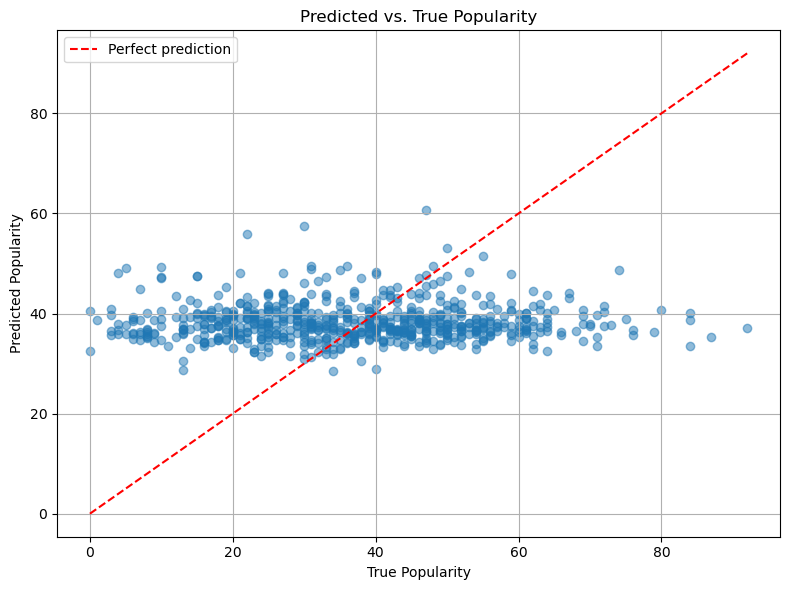

In [16]:
# Extract true labels and images from the validation dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect prediction')
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Predicted vs. True Popularity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [23]:
# Bin popularity into two classes: Top album vs Not Top
df['popularity_class'] = df['popularity'].apply(lambda x: 1 if x >= 60 else 0)

# Update the label column to be the binned popularity class
label_column = 'popularity_class'

# Convert images and labels as before
X = []
y = []

for _, row in df.iterrows():
    image_path = os.path.join(img_dir, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)

# Wrap into tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle, batch, prefetch
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Build the model for binary classification
model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 3
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Output layer (binary classification)
model.add(layers.Dense(1, activation='sigmoid'))

# Early stopping
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])

Epoch 1/20


/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4989 - loss: 0.7789 - val_accuracy: 0.5623 - val_loss: 0.6910
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5428 - loss: 0.7039 - val_accuracy: 0.2994 - val_loss: 0.7793
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5976 - loss: 0.6519 - val_accuracy: 0.3936 - val_loss: 0.7430
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6753 - loss: 0.5900 - val_accuracy: 0.6657 - val_loss: 0.5856
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6721 - loss: 0.5885 - val_accuracy: 0.6869 - val_loss: 0.5735
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7281 - loss: 0.5120 - val_accuracy: 0.4772 - val_loss: 0.7598
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8141 - loss: 0.4021 - val_accuracy: 0.6717 - val_loss: 0.6124
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.8381 - loss: 0.3538 - val_accuracy: 0.3921 - val_loss: 1.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-04-20 12:17:01.331122: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


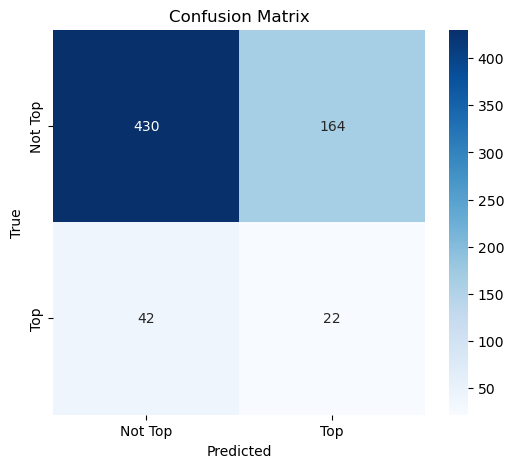

In [24]:
# Get model predictions on the validation dataset
y_pred = model.predict(val_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class labels

# Get the true labels from the validation dataset
y_true = np.concatenate([y for _, y in val_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Top", "Top"], yticklabels=["Not Top", "Top"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
